### Import Lib

In [52]:
import os
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from data_preprocessing import NusaXSentimentDataProcessor
from lstm import LSTMModel



### Import Dataset

In [53]:
data_dir = '../../indonesian'
data_processor = NusaXSentimentDataProcessor(data_dir,sequence_length = 30)# 30 timesteps
print("Preparing data...")
(x_train, y_train), (x_val, y_val), (x_test, y_test) = data_processor.prepare_data()



Preparing data...
Unique labels found: {'positive', 'neutral', 'negative'}
Train data: 500 samples
Validation data: 100 samples
Test data: 400 samples


### Making Keras Model Architecture 

In [54]:
from tensorflow import keras
import tensorflow as tf

def create_and_train_model(x_train, 
                           y_train, 
                           x_val, 
                           y_val, 
                           vocab_size, 
                           num_classes, 
                           model_type='lstm',
                           embedding_dim = 100, 
                           hidden_units=25,
                           epoch=25,
                           batch_size=32,
                           num_layers=1):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, embedding_dim))

    # Pilih jenis RNN
    if model_type.lower() == 'lstm':
        for _ in range(num_layers-1):
            model.add(keras.layers.LSTM(hidden_units,return_sequences=True))
        model.add(keras.layers.LSTM(hidden_units))
    elif model_type.lower() == 'bidirectional_lstm':
        for _ in range(num_layers-1):
            model.add(keras.layers.Bidirectional(keras.layers.LSTM(hidden_units,return_sequences=True)))
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(hidden_units)))
    else:
        raise ValueError("model_type harus salah satu dari: 'lstm', 'simplernn")

    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"\nTraining {model_type.upper()} model with {num_classes} classes...")
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epoch,
        batch_size=batch_size
    )

    return model, history

def preprocess_text_for_prediction(processor: NusaXSentimentDataProcessor, text: str):
    if processor.vectorize_layer is None:
        raise ValueError("Vectorize layer belum diadaptasi. Jalankan prepare_data() dulu.")

    vectorized = processor.vectorize_text(tf.constant([text]))
    return vectorized.numpy()

In [55]:
vocab_size = data_processor.get_vocabulary_size()
num_classes = data_processor.get_num_classes()
print(f"Vocab Size: {vocab_size} Num Classes {num_classes}")
print(vocab_size)

Vocab Size: 2836 Num Classes 3
2836


### Utility Function

In [56]:
def plot_loss(hist, title='Training and Validation Loss'):
    loss = hist.history.get("loss")
    val_loss = hist.history.get("val_loss")

    plt.figure(figsize=(8, 5))
    plt.plot(loss, label='Train Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='red')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Testing

#### 1. Pengaruh Jumlah Layer LSTM

##### 1.1 Single Layer LSTM


Training LSTM model with 3 classes...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4015 - loss: 1.0918 - val_accuracy: 0.4900 - val_loss: 1.0671
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4921 - loss: 1.0518 - val_accuracy: 0.5200 - val_loss: 1.0009
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5307 - loss: 0.9232 - val_accuracy: 0.5600 - val_loss: 0.9046
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6334 - loss: 0.7451 - val_accuracy: 0.6200 - val_loss: 0.9388
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7179 - loss: 0.5746 - val_accuracy: 0.6000 - val_loss: 0.8899
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7389 - loss: 0.5031 - val_accuracy: 0.6200 - val_loss: 0.8941
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7563 - loss: 0.4762 - val_accuracy: 0.6000 - val_loss: 0.9827
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7459 - 

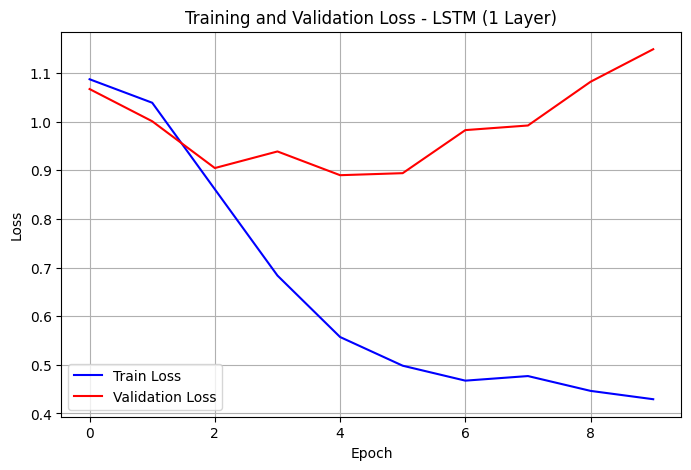

In [57]:
keras_model_lstm_1_layer,hist = create_and_train_model(
    x_train,y_train,x_val,y_val,vocab_size,num_classes,'lstm',
    epoch=10,
    embedding_dim=50,
    hidden_units=30,
    batch_size=32,
    num_layers=1
    )
custom_model_lstm_1_layer = LSTMModel(keras_model_lstm_1_layer)
custom_model_lstm_1_layer.evaluate(x_test=x_test,y_test=y_test,return_output=False)
plot_loss(hist,"Training and Validation Loss - LSTM (1 Layer)")



##### 1.2 Double Layer LSTM


Training LSTM model with 3 classes...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.4608 - loss: 1.0779 - val_accuracy: 0.5000 - val_loss: 1.0056
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5440 - loss: 0.9525 - val_accuracy: 0.5100 - val_loss: 0.9484
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6262 - loss: 0.7588 - val_accuracy: 0.5800 - val_loss: 0.8225
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7021 - loss: 0.5846 - val_accuracy: 0.6200 - val_loss: 0.8097
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7359 - loss: 0.5185 - val_accuracy: 0.6000 - val_loss: 0.8273
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8550 - loss: 0.3701 - val_accuracy: 0.6200 - val_loss: 1.0273
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9486 - loss: 0.2038 - val_accuracy: 0.6300 - val_loss: 1.0856
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9671 - 

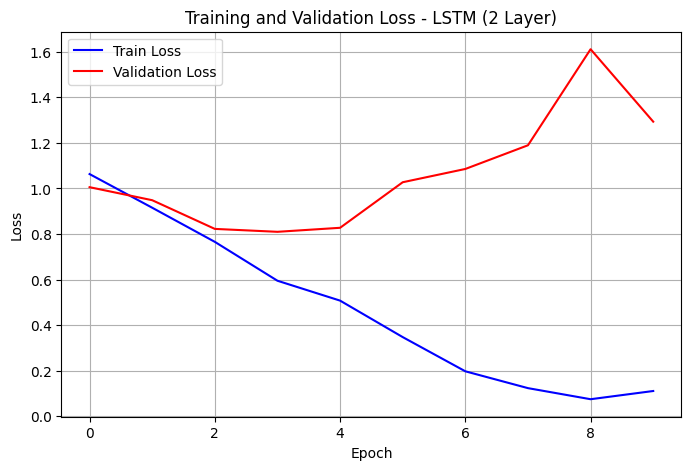

In [58]:
keras_model_lstm_2_layer,hist = create_and_train_model(
    x_train,y_train,x_val,y_val,vocab_size,num_classes,'lstm',
    epoch=10,
    embedding_dim=50,
    hidden_units=30,
    batch_size=32,
    num_layers=2
    )
custom_model_lstm_2_layer = LSTMModel(keras_model_lstm_2_layer)
custom_model_lstm_2_layer.evaluate(x_test=x_test,y_test=y_test,return_output=False)
plot_loss(hist,"Training and Validation Loss - LSTM (2 Layer)")



##### 1.3 Triple Layer LSTM


Training LSTM model with 3 classes...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.3921 - loss: 1.0800 - val_accuracy: 0.4800 - val_loss: 1.0049
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5308 - loss: 0.9197 - val_accuracy: 0.4800 - val_loss: 0.9624
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5926 - loss: 0.7924 - val_accuracy: 0.5900 - val_loss: 0.8321
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7848 - loss: 0.6012 - val_accuracy: 0.6300 - val_loss: 0.8307
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9058 - loss: 0.3682 - val_accuracy: 0.6200 - val_loss: 1.0224
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9356 - loss: 0.2570 - val_accuracy: 0.5900 - val_loss: 1.1339
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9664 - loss: 0.1679 - val_accuracy: 0.5900 - val_loss: 1.3280
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9849 - 

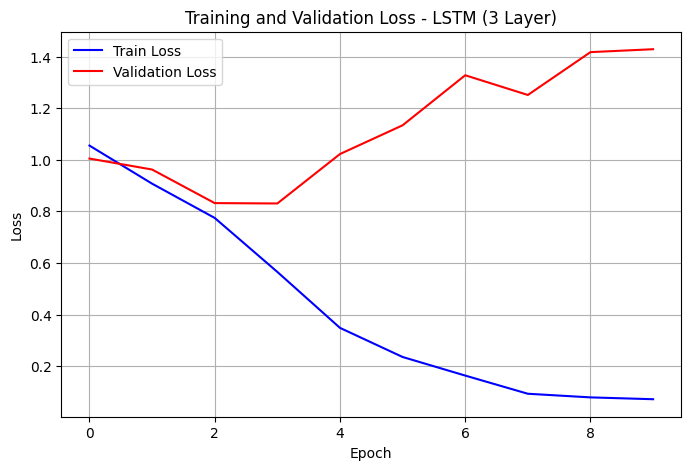

In [59]:
keras_model_lstm_3_layer,hist = create_and_train_model(
    x_train,y_train,x_val,y_val,vocab_size,num_classes,'lstm',
    epoch=10,
    embedding_dim=50,
    hidden_units=30,
    batch_size=32,
    num_layers=3
    )
custom_model_lstm_3_layer = LSTMModel(keras_model_lstm_3_layer)
custom_model_lstm_3_layer.evaluate(x_test=x_test,y_test=y_test,return_output=False)
plot_loss(hist,"Training and Validation Loss - LSTM (3 Layer)")


#### 2. Pengaruh Banyak Cell LSTM per Layer

##### 2.1 16 Cells LSTM


Training LSTM model with 3 classes...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4308 - loss: 1.0910 - val_accuracy: 0.5000 - val_loss: 1.0675
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4863 - loss: 1.0497 - val_accuracy: 0.5000 - val_loss: 1.0270
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5228 - loss: 0.9612 - val_accuracy: 0.5400 - val_loss: 0.9615
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5646 - loss: 0.8412 - val_accuracy: 0.5100 - val_loss: 0.8867
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7255 - loss: 0.6221 - val_accuracy: 0.6300 - val_loss: 0.8237
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7594 - loss: 0.5878 - val_accuracy: 0.6200 - val_loss: 0.8517
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8060 - loss: 0.4762 - val_accuracy: 0.5700 - val_loss: 0.9055
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8833 - 

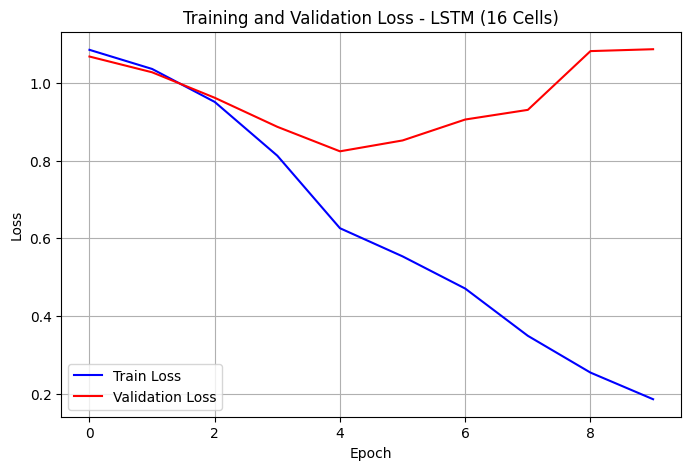

In [60]:
keras_model_lstm_16_cells,hist = create_and_train_model(
    x_train,y_train,x_val,y_val,vocab_size,num_classes,'lstm',
    epoch=10,
    embedding_dim=50,
    hidden_units=16,
    batch_size=32,
    num_layers=1
    )
custom_model_lstm_16_cells = LSTMModel(keras_model_lstm_16_cells)
custom_model_lstm_16_cells.evaluate(x_test=x_test,y_test=y_test,return_output=False)
plot_loss(hist,"Training and Validation Loss - LSTM (16 Cells)")

##### 2.2 64 Cells LSTM


Training LSTM model with 3 classes...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4400 - loss: 1.0887 - val_accuracy: 0.5000 - val_loss: 1.0499
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5559 - loss: 0.9869 - val_accuracy: 0.4900 - val_loss: 0.9426
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5983 - loss: 0.8019 - val_accuracy: 0.5800 - val_loss: 0.8275
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6977 - loss: 0.6222 - val_accuracy: 0.5900 - val_loss: 0.8649
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7172 - loss: 0.5568 - val_accuracy: 0.6100 - val_loss: 0.9550
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7718 - loss: 0.4998 - val_accuracy: 0.6300 - val_loss: 0.8702
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8694 - loss: 0.4139 - val_accuracy: 0.6500 - val_loss: 1.0064
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9200 - 

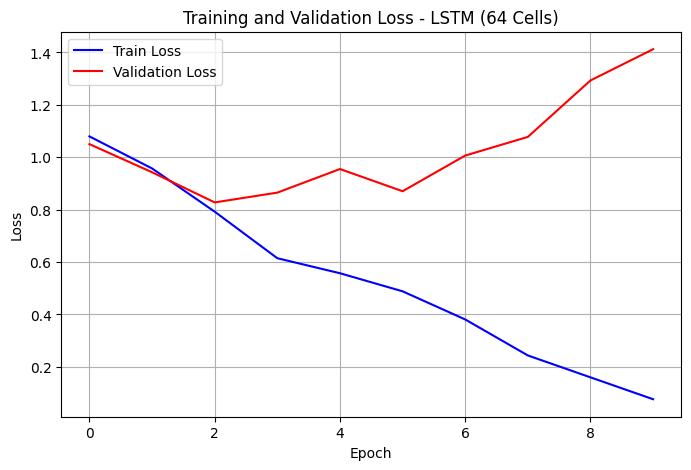

In [61]:
keras_model_lstm_64_cells,hist = create_and_train_model(
    x_train,y_train,x_val,y_val,vocab_size,num_classes,'lstm',
    epoch=10,
    embedding_dim=50,
    hidden_units=64,
    batch_size=32,
    num_layers=1
    )
custom_model_lstm_64_cells = LSTMModel(keras_model_lstm_64_cells)
custom_model_lstm_64_cells.evaluate(x_test=x_test,y_test=y_test,return_output=False)
plot_loss(hist,"Training and Validation Loss - LSTM (64 Cells)")

##### 2.3 128 Cells LSTM


Training LSTM model with 3 classes...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4302 - loss: 1.0851 - val_accuracy: 0.5100 - val_loss: 0.9635
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5319 - loss: 0.8897 - val_accuracy: 0.5300 - val_loss: 0.9023
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6253 - loss: 0.7396 - val_accuracy: 0.6100 - val_loss: 0.9093
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7358 - loss: 0.5546 - val_accuracy: 0.6300 - val_loss: 0.8811
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8833 - loss: 0.3444 - val_accuracy: 0.5500 - val_loss: 1.2845
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8979 - loss: 0.3338 - val_accuracy: 0.6300 - val_loss: 1.1490
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9625 - loss: 0.1348 - val_accuracy: 0.6000 - val_loss: 1.4413
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9686 - 

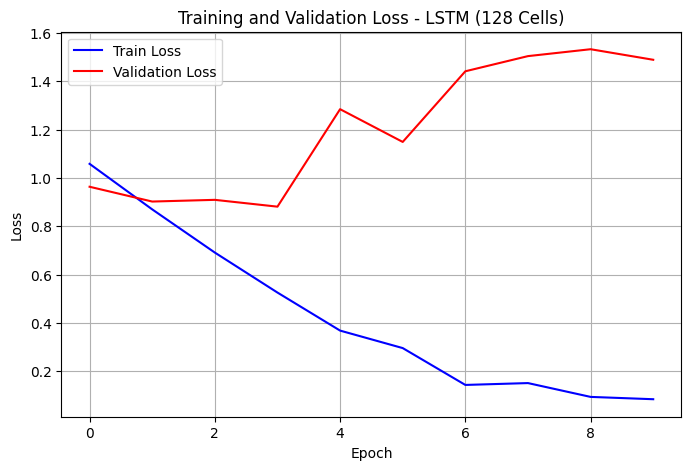

In [62]:
keras_model_lstm_128_cells,hist = create_and_train_model(
    x_train,y_train,x_val,y_val,vocab_size,num_classes,'lstm',
    epoch=10,
    embedding_dim=50,
    hidden_units=128,
    batch_size=32,
    num_layers=1
    )
custom_model_lstm_128_cells = LSTMModel(keras_model_lstm_128_cells)
custom_model_lstm_128_cells.evaluate(x_test=x_test,y_test=y_test,return_output=False)
plot_loss(hist,"Training and Validation Loss - LSTM (128 Cells)")

#### 3. Pengaruh Jenis Layer LSTM Berdasarkan Arah

##### 3.1 Unidirectional LSTM Layer


Training LSTM model with 3 classes...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3836 - loss: 1.0924 - val_accuracy: 0.5000 - val_loss: 1.0665
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5172 - loss: 1.0481 - val_accuracy: 0.5100 - val_loss: 1.0147
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5266 - loss: 0.9587 - val_accuracy: 0.4800 - val_loss: 0.9271
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5946 - loss: 0.7883 - val_accuracy: 0.6400 - val_loss: 0.8154
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7264 - loss: 0.5843 - val_accuracy: 0.5900 - val_loss: 1.1714
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7255 - loss: 0.6485 - val_accuracy: 0.5900 - val_loss: 0.9243
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6887 - loss: 0.5611 - val_accuracy: 0.6100 - val_loss: 0.9228
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7534 - 

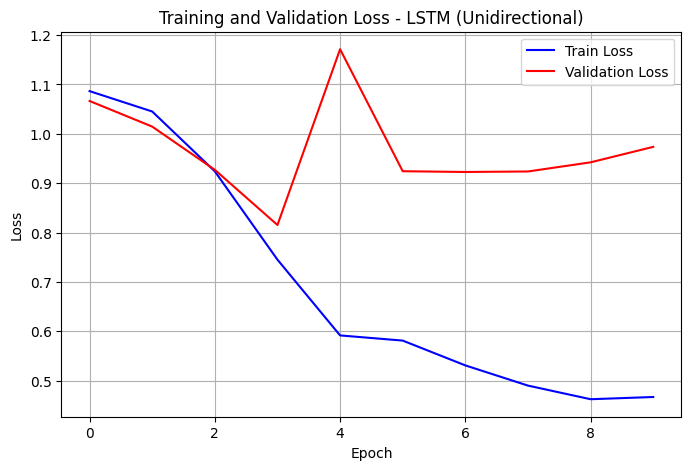

In [63]:
keras_model_lstm_unidirectional,hist = create_and_train_model(
    x_train,y_train,x_val,y_val,vocab_size,num_classes,'lstm',
    epoch=10,
    embedding_dim=50,
    hidden_units=32,
    batch_size=32,
    num_layers=1
    )
custom_model_lstm_unidirectional = LSTMModel(keras_model_lstm_unidirectional)
custom_model_lstm_unidirectional.evaluate(x_test=x_test,y_test=y_test,return_output=False)
plot_loss(hist,"Training and Validation Loss - LSTM (Unidirectional)")

##### 3.2 Bidirectional LSTM Layer


Training BIDIRECTIONAL_LSTM model with 3 classes...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4661 - loss: 1.0897 - val_accuracy: 0.5000 - val_loss: 1.0510
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5119 - loss: 1.0069 - val_accuracy: 0.5100 - val_loss: 0.9534
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5791 - loss: 0.8282 - val_accuracy: 0.5300 - val_loss: 0.9053
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7251 - loss: 0.6926 - val_accuracy: 0.6500 - val_loss: 0.7901
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8782 - loss: 0.4082 - val_accuracy: 0.6500 - val_loss: 0.8678
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9153 - loss: 0.2819 - val_accuracy: 0.6600 - val_loss: 0.9272
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9437 - loss: 0.2072 - val_accuracy: 0.7200 - val_loss: 0.8178
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accur

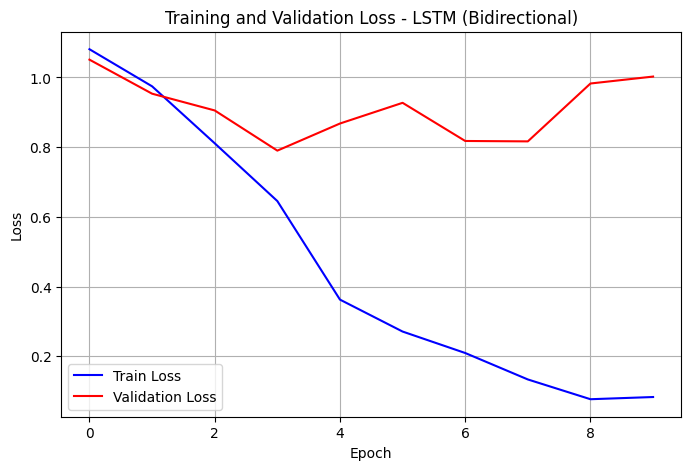

In [64]:
keras_model_lstm_bidirectional,hist = create_and_train_model(
    x_train,y_train,x_val,y_val,vocab_size,num_classes,'bidirectional_lstm',
    epoch=10,
    embedding_dim=50,
    hidden_units=32,
    batch_size=32,
    num_layers=1
    )
custom_model_lstm_bidirectional = LSTMModel(keras_model_lstm_bidirectional)
custom_model_lstm_bidirectional.evaluate(x_test=x_test,y_test=y_test,return_output=False)
plot_loss(hist,"Training and Validation Loss - LSTM (Bidirectional)")

### Save Trained LSTM Models

In [65]:
def save_keras_model(model, model_name):
    model_dir = 'saved_models'
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f"{model_name}.keras")
    model.save(model_path)
    print(f"Model saved to {model_path}")

In [67]:
save_keras_model(keras_model_lstm_1_layer,"lstm_1_layer")
save_keras_model(keras_model_lstm_2_layer,"lstm_2_layer")
save_keras_model(keras_model_lstm_3_layer,"lstm_3_layer")
save_keras_model(keras_model_lstm_16_cells,"lstm_16_cells")
save_keras_model(keras_model_lstm_64_cells,"lstm_64_cells")
save_keras_model(keras_model_lstm_128_cells,"lstm_128_cells")
save_keras_model(keras_model_lstm_unidirectional,"lstm_unidirectional")
save_keras_model(keras_model_lstm_bidirectional,"lstm_bidirectional")

Model saved to saved_models\lstm_1_layer.keras
Model saved to saved_models\lstm_2_layer.keras
Model saved to saved_models\lstm_3_layer.keras
Model saved to saved_models\lstm_16_cells.keras
Model saved to saved_models\lstm_64_cells.keras
Model saved to saved_models\lstm_128_cells.keras
Model saved to saved_models\lstm_unidirectional.keras
Model saved to saved_models\lstm_bidirectional.keras


### Loading Model

In [68]:
def load_keras_model(model_name):
    model_dir = 'saved_models'
    model_path = os.path.join(model_dir, f"{model_name}.keras")
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model {model_name} not found at {model_path}")
    return keras.models.load_model(model_path)

In [70]:
saved_lstm_1_layer = load_keras_model("lstm_1_layer")
custom_model_lstm_1_layer_saved = LSTMModel(saved_lstm_1_layer)
custom_model_lstm_1_layer_saved.evaluate(x_test, y_test, return_output=False)

F1 Score (macro): 0.4812
Loss: 0.7830
Accuracy: 0.6250
